**About:** This notebook contains the experiment to cluster the  
(TPHYSTND,PHQ) and find the corresponding (SOLIN,PS,LHFLX,SHFLX) on the normalized version of the dataset.

# Imports

In [4]:
from backend.imports import *
from backend.utils import *
from backend.data_generator import DataGenerator
from sklearn.cluster import MiniBatchKMeans

# Data Transformations

In [5]:
TRAINDIR = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'
path = '/home/ankitesh/PDE/CbrainPDE/backend/constDicts/'
path_hyam = 'hyam_hybm.pkl'

hf = open(path+path_hyam,'rb')
hyam,hybm = pickle.load(hf)
scale_dict = load_pickle('/home/ankitesh/PDE/CbrainPDE/backend/constDicts/009_Wm2_scaling.pkl')

In [6]:
PHQ_idx = slice(0,30)
TPHYSTND_idx = slice(30,60)

In [38]:
batch_size = 10000

### Load the dataset

In [7]:
TRAINFILE = 'CI_SP_M4K_train_shuffle.nc'
NORMFILE = 'CI_SP_M4K_NORM_norm.nc'
VALIDFILE = 'CI_SP_M4K_valid.nc'

in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

In [39]:
train_data_m4k =  DataGenerator(
    data_fn = TRAINDIR+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=batch_size,
    shuffle=True,
    normalize_flag=True
)

# Model

We are going to cluster on the basis of PHQ and TPHYSTND

In [44]:
n_batches = train_data_m4k.n_batches
n_clusters = 5
kmeans = MiniBatchKMeans(n_clusters=n_clusters,random_state=0,batch_size=n_batches)

In [47]:
for i in tqdm(range(train_data_m4k.n_batches)):
    Y = train_data_m4k[i][1]
    PHQ = Y[:,PHQ_idx].mean(axis=1)
    TPHYSTND = Y[:,TPHYSTND_idx].mean(axis=1)
    X = np.vstack((PHQ,TPHYSTND)).T
    kmeans = kmeans.partial_fit(X)

/home/ankitesh/miniconda3/envs/PDE-Net/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [48]:
kmeans.cluster_centers_

array([[  1.7745814,  -2.4095986],
       [-24.123919 ,  25.563284 ],
       [-50.329346 ,  53.60023  ],
       [ -6.5900526,   7.0280023],
       [-90.602615 ,  95.702545 ]], dtype=float32)

# Results

Plotting the clusters and some datapoints

/home/ankitesh/miniconda3/envs/PDE-Net/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


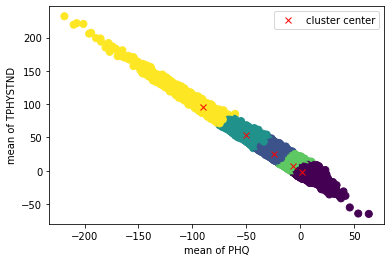

In [69]:
#plot 100000 data points i.e 
for i in tqdm(range(int(1000000/batch_size))):
    Y = train_data_m4k[i][1]
    PHQ = Y[:,PHQ_idx].mean(axis=1)
    TPHYSTND = Y[:,TPHYSTND_idx].mean(axis=1)
    X = np.vstack((PHQ,TPHYSTND)).T
    pred = kmeans.predict(X)
    plt.scatter(X[:,0],X[:,1],c=pred, s=50, cmap='viridis')
plt.plot(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],'x',c='r')
plt.xlabel("mean of PHQ")
plt.ylabel("mean of TPHYSTND")
plt.legend(['cluster center'])